In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np
from dataloader import dataloader, dataset_for_classification
from adaboost_pytorch import AdaboostClassifier
from face_detect_slidwin_based import faceDetection, evaluateFaceDetection

In [2]:
train_data, test_data = dataloader("./FDDB-folds/", "./originalPics/")

d:\College\CS376\a5\dataloader.py:115: RuntimeWarning: divide by zero encountered in double_scalars
  t = np.arctan(b*(1/np.tan(phi))/a)


2306
2306
539
(305, 449)
150 60 154 20
211 156 171 87
385 296 187 47


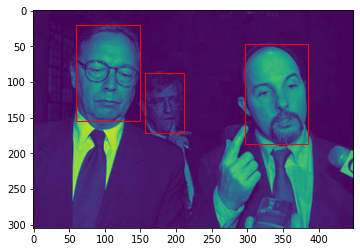

In [6]:
print(len(train_data["img"]))
print(len(train_data["faces"]))
print(len(test_data['img']))
print(train_data["img"][1].shape)
fig, ax = plt.subplots()
ax.imshow(train_data["img"][1])
for max_x, min_x, max_y, min_y in train_data["faces"][1]:
    print(max_x, min_x, max_y, min_y)
    width = max_x - min_x
    height = max_y - min_y
    rect = patches.Rectangle((min_x, min_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

#### Generate dataset for classification

In [6]:
train_classification = dataset_for_classification(train_data, 10)
test_classification = dataset_for_classification(test_data, 10)

31332
8272
7460


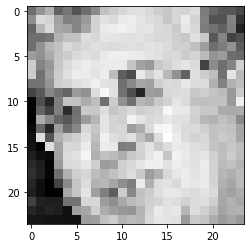

In [8]:
print(len(train_classification['img']))
print(train_classification['labels'].count(1))
print(len(test_classification['img']))
plt.imshow(train_classification['img'][0], cmap='Greys')

#### Training an adaboost classifier to classify faces

In [9]:
adaboost_classifier = AdaboostClassifier([24,24], 1000)
adaboost_classifier.fit(np.array(train_classification['img']), np.array(train_classification['labels']))

100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]


In [10]:
eval = adaboost_classifier.evaluate(np.array(test_classification['img']),np.array(test_classification['labels']))
print("Adaboost Classifier evaluation:")
print("accuracy:", eval[0])
print("precision:", eval[1])
print("recall:", eval[2])

Adaboost Classifier evaluation:
accuracy: 0.8967828418230563
precision: 0.7878653675819309
recall: 0.8594202898550725


In [11]:
faces = faceDetection(test_data['img'], adaboost_classifier, [int(72 * (1.25**i)) for i in range(8)], 1, 0.5, 0.5)

100%|██████████| 539/539 [00:16<00:00, 33.35it/s]


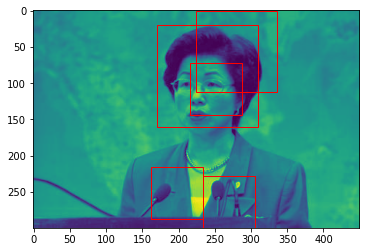

In [12]:
fig, ax = plt.subplots()
ax.imshow(test_data["img"][0])
for max_x, min_x, max_y, min_y in faces[0]:
    # print(max_x, min_x, max_y, min_y)
    width = max_x - min_x
    height = max_y - min_y
    rect = patches.Rectangle((min_x, min_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [14]:
precision, recall = evaluateFaceDetection(faces, test_data['faces'], 0.5)
print("precision:", precision, "recall:", recall)

precision: 0.05763517528223411 recall: 0.3748792270531401


#### Plot precision-recall curve with different confidence threshold

In [19]:
precisions, recalls = [], []
for thres in [0.5,0.505,0.51,0.515,0.52,0.525,0.53,0.535,0.54]:
    faces = faceDetection(test_data['img'], adaboost_classifier, [int(72 * (1.25**i)) for i in range(8)], 1, thres, 0.5)
    precision, recall = evaluateFaceDetection(faces, test_data['faces'], 0.5)
    precisions.append(precision)
    recalls.append(recall)

100%|██████████| 539/539 [00:15<00:00, 34.07it/s]


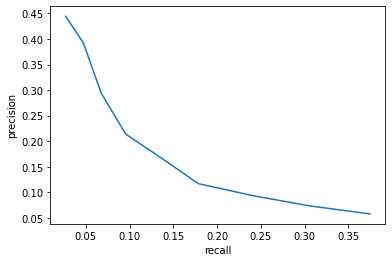

: 

In [22]:
plt.plot(recalls, precisions)
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

In [1]:
from nn_model import Yolov1
import torch

model = Yolov1(1,7,2,20)
x = torch.randn([16,1,448,448])
y = torch.abs(torch.randn([16,7,7,25]))
y[..., 20] = 1
y_hat = model(x).reshape(-1, 7, 7, 30)
print(y_hat.shape)
print(y_hat[0,0,0,20:])

torch.Size([16, 7, 7, 30])
tensor([-0.1715, -0.1873, -0.0769, -0.0752,  0.0012,  0.0627,  0.1572, -0.0942,
         0.0349,  0.2599], grad_fn=<SliceBackward0>)


In [19]:
import torch.nn as nn

box_exists = y[..., 20].unsqueeze(3)
print(box_exists.shape)
bestbox = torch.zeros([16,7,7,1])
box_predictions = box_exists * (
    bestbox * y_hat[..., 26:30] + 
    (1 - bestbox) * y_hat[..., 21:25]
)
box_targets = box_exists * y[..., 21:25]
box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * \
    torch.sqrt(torch.abs(box_predictions[..., 2:4]) + 1e-6)
box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
print(box_predictions.shape)
print(box_targets.shape)
print(box_predictions[0,0,0,:])
mse = nn.MSELoss(reduction="mean")
box_loss = mse(
    # (N, S, S, 4) -> (N*S*S, 4)
    torch.flatten(box_predictions, end_dim=-2),
    torch.flatten(box_targets, end_dim=-2)
)
print(box_loss)

torch.Size([16, 7, 7, 1])
torch.Size([16, 7, 7, 4])
torch.Size([16, 7, 7, 4])
tensor([ 0.0697,  0.0859,  0.4805, -0.2740], grad_fn=<SliceBackward0>)
tensor(1.0345, grad_fn=<MseLossBackward0>)


In [1]:
from nn_dataloader import FDDBDataset
from utils import yoloLabel_to_boxes

dataset = FDDBDataset("./FDDB-folds/FDDB-fold-09-ellipseList.txt", "./originalPics/")

tensor([[[112, 114, 116,  ..., 134, 130, 130],
         [112, 115, 116,  ..., 134, 130, 130],
         [113, 115, 116,  ..., 134, 130, 130],
         ...,
         [ 51,  51,  45,  ..., 147, 149, 150],
         [ 53,  52,  47,  ..., 149, 149, 150],
         [ 55,  54,  49,  ..., 150, 150, 150]]], dtype=torch.int32)
(448, 448, 3)


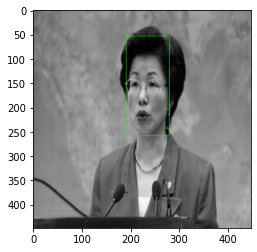

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots()
img = dataset[0][0]
label = dataset[0][1]
print(img.float().int())
rgb_img = np.stack((img[0], img[0], img[0]), axis=-1)
# ax.imshow(rgb_img)
print(rgb_img.shape)
boxes = yoloLabel_to_boxes(img[0].shape[0], img[0].shape[1], label, 7, 2, 0)
for cx, cy, w, h in boxes:
    # print(cx, cy, w, h)
    # rect = patches.Rectangle((cx - w/2, cy - h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # ax.add_patch(rect)
    x1 = int(max(cx - w/2, 0))
    x2 = int(max(cx + w/2, 0))
    y1 = int(max(cy - h/2, 0))
    y2 = int(max(cy + h/2, 0))
    rgb_img[y1:y2, x1, :] = [0, 255, 0]
    rgb_img[y1:y2, x2, :] = [0, 255, 0]
    rgb_img[y1, x1:x2, :] = [0, 255, 0]
    rgb_img[y2, x1:x2, :] = [0, 255, 0]
ax.imshow(rgb_img)

In [24]:
a = np.zeros((448,448,3))
np.moveaxis(a, 2, 0).shape

(3, 448, 448)

[[0.8292286396026611, 89.44878005981445, 153.1776466369629, 149.50355529785156, 256.7625427246094], [1.142149567604065, 238.26715850830078, 161.82167053222656, 137.4309844970703, 285.6735534667969], [1.163101077079773, 255.5941505432129, 168.8377227783203, 131.71713256835938, 237.157470703125]]
[array([  1.16310108, 255.59415054, 168.83772278, 131.71713257,
       237.1574707 ]), array([  0.82922864,  89.44878006, 153.17764664, 149.5035553 ,
       256.76254272])]


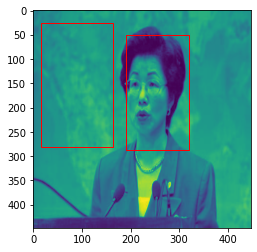

In [2]:
from nn_model import Yolov1
from utils import nonMaximumSuppression
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots()
model = Yolov1(1,7,2,0)
model.load_state_dict(torch.load("./model/new/epoch=43-val_loss=0.01518.ckpt")['state_dict'])
model.to('cuda')
img = dataset[0][0]
y_hat = model(img.unsqueeze(0).float().to('cuda')).detach().cpu().numpy().reshape((-1,7,7,10))[0]
ax.imshow(img[0])
boxes = yoloLabel_to_boxes(img[0].shape[0], img[0].shape[1], y_hat, 7, 2, 0)
print(boxes)
boxes = nonMaximumSuppression(boxes, 0.5)
print(boxes)
for _, cx, cy, w, h in boxes:
    # print(cx, cy, w, h)
    rect = patches.Rectangle((cx - w/2, cy - h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)